In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as stats
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;

from sklearn.feature_selection import RFE
# from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import learning_curve, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### В данном ноутбуке представлен процесс построения скоркарты, но с использованием дополнительных видов моделей:
- DecisionTree (дерево решений)
- RandomForest (классический случайный лес, объединение деревьев решений)
- LinearTree (дерево решений с логистической регрессией в листе)

Основное отличие по сравнению с классическим способом - способ преобразования модели в SQL.

In [2]:
# !pip install mlxtend
# !pip install lightgbm
# !pip install pymysql
# !pip install scikit-plot
# !pip install tqdm

# Дополнительные библиотеки для преобразования моделей в SQL:
# !pip install sqlparse
# !pip install skompiler
# !pip install catboost

In [251]:
from autoscoring.lineartree import LinearTreeClassifier

In [3]:
%load_ext autoreload
%autoreload 2

In [327]:
from autoscoring import IDF
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning, correct_binning_dict, print_feature_bins
from autoscoring.sql_converter import convert_linear_tree_to_sql, convert_model_to_sql
from autoscoring.AS_models import *

In [5]:
df = pd.read_excel('data/slkz_SolvaStreet.xlsx', sheet_name='result 1')

# Добавить, если имя целевой переменной отличается от 'target'
# df['target'] = 

# df['date_requested'] = pd.to_datetime(df['date_requested'])
DATE = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df[DATE] = pd.to_datetime(df[DATE])
df_req = df[['credit_id', DATE]]
df['y'] = df['target']
y = df.y

In [ ]:
# В некоторых случаях при загрузке из excel файла может произойти проблема,
# связанная с тем, что в excel вещественные числа разделяются запятой,
# а в python разделение идёт по точке.
# Если возникла такая проблема, то можно заменить все запятые на точки и сделать преобразование типовю

# Запускать эту ячейку, только если есть данная проблема. Иначе можно пропустить.

# for col in df.select_dtypes(include=object).columns:
#     df[col] = df[col].apply(lambda x: str(x).replace(',', '.'))

# df = df.apply(pd.to_numeric, errors='ignore')

In [6]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCORE' in var or 'scoring' in var or 'street' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

In [7]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
# Можно задать список признаков, который не будет учавствовать в предобработке
ignore_vars = ['date_requested', 'credit_id', 'target', DATE]
df, else_df = replace_not_frequent_2(df, cat_vars, num_min=min_num, ignore_vars=ignore_vars)

# Drop columns with only 1 value
df = drop_single_value_column(df, except_cols=ignore_vars)

In [8]:
# Если вы не разделяете сэмпл на df_out, то можете закомментировать этот кусок,
# и вместо него запустить:
# df_out, y_out = None, None

df_out = df[df['date_requested'] >= '2021-01-01']
df = df[df['date_requested'] < '2021-01-01']
y_out = df_out.y

In [9]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.2, stratify=df.y, random_state=123)

In [33]:
df_train.shape, df_test.shape, df_out.shape

((7178, 265), (1795, 265), (3134, 265))

#### Построение WOE таблицы

In [21]:
# Задаём набор признаков для формирования биннинга.
# Набор колонок, который не будет учавствовать в построении карты
technical_features = ['credit_id', 'date_requested', 'type',
                        'target', 'y', DATE]
technical_features = list(set(technical_features))
# Задаём набор признаков, которые будут учавствовать в биннинге,
# для этого удаляем все ненужные признаки из общего списка переменных.
features = df_train.drop(
    technical_features
, axis=1).columns

target_name = 'target'  # Наименование столбца - таргета
# Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# только в исключительных ситуациях
min_bin_size = 0.05
max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# Как определять WOE для пропусков, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
nan_to_woe = 'max_cat'
# Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
else_to_woe = 'max_cat'
# Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
monotonic = False
n_jobs = 4  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df_train, features, target_name,
                                                         max_bin_count=max_bin_count,
                                                         min_bin_size=min_bin_size,
                                                         nan_to_woe=nan_to_woe,
                                                         else_to_woe=else_to_woe,
                                                         monotonic=monotonic,
                                                         n_jobs=n_jobs)

# iv_df - таблицы WOE биннинга
# dropped_feats - набор переменных, для которых биннинг не посчитался,
# т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный,
# также стоит отдельно смотреть, что может быть такая ситуация, что переменная не имеет хорошего 
# разделения, но NaN значения хорошо отделяются. Тогда стоит отдельно заполнять NaN некоторым эмпирическим значением.
# feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# по которым признак не очень хороший, можно игнорировать
# best_features - набор признаков после предварительного отбора внутри AutoML,
# можно использовать при дальнейшем отборе, можно проигнорировать
# auto_woe - техническая переменная, можно игнорировать

[LightGBM] [Info] Number of positive: 474, number of negative: 5268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19198
[LightGBM] [Info] Number of data points in the train set: 5742, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082550 -> initscore=-2.408199
[LightGBM] [Info] Start training from score -2.408199


In [10]:
# Если ранее для скоркарты была создана таблица iv_df, то её можно загрузить из excel.
iv_df = pd.read_excel('result/iv_df.xlsx', index=0)

In [17]:
# Набор обязательных признаков, которые должны остаться несмотря на отбор.
# Если они не нужны, можно оставить пустым или закомментировать.
mandatory_feats = ['credits_active_owner', 'credits_all_owner']
mandatory_feats_woe = ['WOE_' + col for col in mandatory_feats]

In [11]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.05
vars = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()

# Можно закомментировать, если не надо добавлять обязательных признаков. 
# vars = add_mandatory_feats(vars, mandatory_feats)

print(len(vars))

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(vars)]

78


In [12]:
iv_co = None
X_train, y_train = transform_df_to_woe(df_train[vars], y_train, IV, iv_df, iv_cut_off=iv_co)
X_test, y_test = transform_df_to_woe(df_test[vars], y_test, IV, iv_df, iv_cut_off=iv_co)
X_out, y_out = transform_df_to_woe(df_out[vars], y_out, IV, iv_df, iv_cut_off=iv_co)

Features left after IV drop: 78
DONE!
Features left after IV drop: 78
DONE!
Features left after IV drop: 78
DONE!


In [13]:
X_train.columns = 'WOE_' + X_train.columns
X_test.columns = 'WOE_' + X_test.columns
X_out.columns = 'WOE_' + X_out.columns

#### Отбор признаков

##### Т.к. мы не будем использовать логистическую регрессию, а обучим другие модели, то отбор признаков немного меняется. Например нам необязательно отсеивать признаки по корреляциям.

In [14]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по DATE (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества интервалов большего num_bad_intervals.
# Т.е. например, если gini_min=0.05 и num_bad_intervals=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.05  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_intervals = 2  # 2 месяца/недели по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week

gini_feats, df_gini_months = gini_month_selection(X_train, df_train, gini_min=gini_min,
                                                  num_bad_intervals=num_bad_intervals, date_name=date_name,
                                                  intervals=intervals)

In [15]:
print(len(list(gini_feats)))
df_gini_months[df_gini_months['vars'].isin(gini_feats)]

78


,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,WOE_days_from_fc_d_requested,0.047,0.010,0.085,0.114,0.050,0.124,0.101,0.134
1,WOE_credits_active_owner,0.030,0.122,0.166,0.133,0.216,0.101,0.179,0.185
2,WOE_credits_all_owner,0.124,0.039,0.320,0.209,0.268,0.229,0.293,0.390
3,WOE_monthly_instalments_owner,0.020,0.098,0.116,0.214,0.277,0.127,0.222,0.279
4,WOE_mnt_outstand_balance,0.016,0.022,0.090,0.166,0.311,0.149,0.271,0.189
...,...,...,...,...,...,...,...,...,...
73,WOE_industry,0.122,0.155,0.179,0.151,0.207,0.091,0.300,0.266
74,WOE_post,0.057,0.158,0.100,0.187,0.191,0.151,0.278,0.268
75,WOE_work_num_1,-0.018,0.091,0.131,0.130,0.082,0.154,0.249,0.217
76,WOE_work_num_2,0.083,-0.098,0.068,-0.016,0.106,0.124,0.223,0.224


In [105]:
# Считаем однофакторный gini для train, test, out.
# И на основе этих значений удаляем нестабильные признаки.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, gini_feats)
gini_by_vars = gini_univariate_selection(gini_by_vars, cut_off=0.6)
gini_feats = gini_by_vars['vars'].values

,vars,gini_train,gini_test,gini_out
31,WOE_cnt_IL_all,0.277,0.288,0.289
29,WOE_cnt_IL_comp,0.267,0.278,0.293
47,WOE_last_deduction_date,0.264,0.229,0.042
33,WOE_cnt_IL_all_no_Crd,0.258,0.257,0.292
12,WOE_fc_credits_all_owner,0.255,0.232,0.282
...,...,...,...,...
26,WOE_average_amount_opv_div_frst_cr,0.099,0.074,0.026
27,WOE_average_monthly_income_div_frst_cr,0.097,0.071,0.026
28,WOE_conf_income_per_div_frst_cr,0.096,0.071,0.024
0,WOE_days_from_fc_d_requested,0.095,0.053,0.115


In [116]:
# Считаем средние значения WOE по каждому признаку для значений таргета 0 и 1,
# чем больше их разница, тем по логике лучше разделяющая способность признака.
# Потом удаляем нестабильные признаки, у которых значения сильно изменяеются для train/test/out.
df_woe_diff = calc_woe_target_differences(X_train, X_test, X_out, y_train, y_test, y_out, gini_feats)
df_woe_diff = woe_univariate_selection(df_woe_diff)
woe_feats = df_woe_diff['vars'].values

In [16]:
# # Отбираем признаки по их значимости во время построения Деревьев решений.
# top_n = 55  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
# rf_feats, rf_imp = rf_feature_selection(X_train[gini_feats], y_train, top_n=top_n)

In [246]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 50  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
n_repeats = 200  # Кол-во перемешиваний признака, чем больше, тем точнее оченка.
tf_feats, tf_imp = permutation_two_forest_selection(X_train[woe_feats], y_train, top_n=top_n, n_repeats=n_repeats)

In [250]:
tf_feats = tf_imp.iloc[:55]['feature'].values

In [286]:
feat_to_del = ['WOE_PTI_11', 'WOE_last_deduction_date', 'WOE_mail_score',
               'WOE_pti7', 'WOE_fc_mail_score', 'WOE_reg', 'WOE_centre_completed',
               'WOE_fc_sum_per_cred', 'WOE_sum_per_cred', 'WOE_fc_mnt_outstand_balance',
               'WOE_fc_his_w_pay_st_by_cls_crd_days', 'WOE_requested_credit_count_days',
               'WOE_mnt_outstand_balance']

feat_for_cat_select = list(set(tf_feats) - set(feat_to_del))

In [287]:
cat_params = {'eval_metric': 'AUC', 'iterations': 40, 'depth': 4,
              'min_data_in_leaf': 200, 'random_seed': 0}

cat_feats = catboost_feat_selection(X_train, X_test, y_train, y_test,
                                    feat_for_cat_select, cat_params=cat_params,
                                    num_features=25, steps=10)

##### Так же нам можно брать больше признаков в модель, например 15-30.

In [ ]:
# Сохраянем все пройденные этапы отбора признаков.
selection_stages = {
    'исходный набор': features,
    'WOE биннинг': iv_df['VAR_NAME'].unique(),
    # 'корреляции': corr_feats,
    'однофакторный gini по месяцам': gini_feats,
    'features importance деревьев решений': rf_feats,
    'permutation importance двухлесовый метод': tf_feats,
    # 'отбор функцией feature_selection("bf")': X_train_res.columns,
}
name = 'result/selection_stages.xlsx'
save_selection_stages(selection_stages, name)

In [288]:
vars_woe = cat_feats
# vars_woe = add_mandatory_feats(vars_woe, mandatory_feats_woe)
print(vars_woe)

['WOE_days_from_fc_d_requested', 'WOE_credits_all_owner', 'WOE_capsTotalAmountL6m', 'WOE_monthly_instalments_owner', 'WOE_his_w_pay_st_by_cls_crd_days', 'WOE_his_w_pay_st_by_cls_crd_sum', 'WOE_cnt_error_enpf', 'WOE_avg_fr_age', 'WOE_KMF_completed', 'WOE_h_cl_sum_div_days', 'WOE_kaspi_completed', 'WOE_fc_credits_all_owner', 'WOE_fc_monthly_instalments_owner', 'WOE_NumberOfOverdueInstalmentsMax', 'WOE_r_reg', 'WOE_fc_h_cl_sum_div_days', 'WOE_fcb_first_cred_open', 'WOE_fcb_first_cred_open_act', 'WOE_average_monthly_income_div_frst_cr', 'WOE_cnt_IL_comp', 'WOE_cnt_IL_all', 'WOE_cnt_IL_all_no_Crd', 'WOE_bor_age', 'WOE_DTI_2', 'WOE_capsMaxAmnt']


In [307]:
add_feats = ['WOE_capsTotalAmountL3m', 'WOE_KMF_completed']
drop_feats = ['WOE_fc_credits_all_owner', 'WOE_fc_monthly_instalments_owner']
vars_woe = list(set(vars_woe + add_feats) - set(drop_feats))

#### Обучение модели, требуется выбрать одну из них, а остальные закомментировать.

In [364]:
df_train_m = X_train[vars_woe]
df_test_m = X_test[vars_woe]
df_out_m = X_out[vars_woe]

# params = {
#     'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
#     'class_weight': {0: 1, 1: 4}, 'random_state': 142
# }
# Обучаем модель на данных полученных после удаления аномалий.
# logreg = LogisticRegression(**params).fit(df_train_m, y_train)

# Требуется закомментировать не нужные модели и оставить только одну выбранную.

# Обучаем дерево решений.
# params_tree = {'max_depth': 8, 'min_samples_leaf': 0.05, 'class_weight': {0: 1, 1: 4},
#                  'random_state': 123}
# model = DecisionTreeClassifier(**params_tree).fit(df_train_m, y_train)

# Обучаем случайный лес.
# params_forest = {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.05,
#                  'class_weight': {0: 1, 1: 4}, 'random_state': 123}
# model = RandomForestClassifier(**params_forest).fit(df_train_m, y_train)

# Обучаем модель LinearTree - дерево решений с логистическими регрессиями в листах.
params_logreg = {'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
                 'class_weight': {0: 1, 1: 4}, 'random_state': 142}
model = LinearTreeClassifier(
            base_estimator=LogisticRegression(**params_logreg),
            max_depth=4,
            min_samples_leaf=0.15,
).fit(df_train_m, y_train)


predict_proba_train = model.predict_proba(df_train_m)[:, 1]
predict_proba_test = model.predict_proba(df_test_m)[:, 1]
predict_proba_out = model.predict_proba(df_out_m)[:, 1]

Gini_train = round(2 * roc_auc_score(y_train, predict_proba_train) - 1, 3)
Gini_test = round(2 * roc_auc_score(y_test, predict_proba_test) - 1, 3)
Gini_out = round(2 * roc_auc_score(y_out, predict_proba_out) - 1, 3)

print('---------------------------------------------------------------------------------------------')
print('| Gini train =', Gini_train, '| Gini test =', Gini_test,  '| Gini out =', Gini_out, '|')
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
| Gini train = 0.585 | Gini test = 0.459 | Gini out = 0.38 |
---------------------------------------------------------------------------------------------


In [326]:
df_perm_imp = calc_permutation_importance(model, X_test[vars_woe], y_test, n_repeats=500, n_jobs=4)
df_perm_imp

,mean_imp,feature,percentile_imp
15,0.030455,WOE_r_reg,100.000000
6,0.023516,WOE_capsTotalAmountL3m,95.833333
0,0.021385,WOE_cnt_IL_all,91.666667
23,0.018891,WOE_fc_h_cl_sum_div_days,87.500000
12,0.018687,WOE_days_from_fc_d_requested,83.333333
2,0.017371,WOE_DTI_2,79.166667
3,0.014723,WOE_capsTotalAmountL6m,75.000000
16,0.014374,WOE_cnt_error_enpf,70.833333
1,0.014311,WOE_his_w_pay_st_by_cls_crd_sum,66.666667
9,0.013313,WOE_cnt_IL_comp,62.500000


#### Функции для ручного подбора признаков

In [329]:
# Здесь требуется последовательно указать train, test, out выборки,
# если out - отсутствует, поставить None.
# При этом стоит указать не все признаки, а набор признаков после
# предварительного отбора - rf_feats, gini_feats
X_all = [X_train[feat_for_cat_select], X_test[feat_for_cat_select], X_out[feat_for_cat_select]]
y_all = [y_train, y_test, y_out]

# Набор признаков, который оценить при удалении.
vars_to_exclude = df_perm_imp.iloc[-10:]['feature'].values

# Считаем, что будет, если убрать один из признаков.
# Напротив каждого признака - gini модели после удаления этого признака.
df_var_ginis = feature_exclude_model(X_all, y_all, list(vars_woe), list(vars_to_exclude), iv_df, model)
df_var_ginis.sort_values(by='gini_test', ascending=False)

,var_name,gini_train,gini_test,gini_out,IV
0,with all,0.530272,0.466855,0.465245,
6,WOE_kaspi_completed,0.516274,0.45411,0.479470,0.1129
7,WOE_capsMaxAmnt,0.532285,0.452313,0.461642,0.1721
4,WOE_his_w_pay_st_by_cls_crd_days,0.515321,0.451556,0.477294,0.0513
5,WOE_average_monthly_income_div_frst_cr,0.540194,0.450307,0.462523,0.0534
2,WOE_fcb_first_cred_open_act,0.524262,0.448381,0.475232,0.0902
10,WOE_KMF_completed,0.539854,0.446536,0.458407,0.1059
8,WOE_avg_fr_age,0.554562,0.444861,0.460637,0.0822
1,WOE_fcb_first_cred_open,0.542468,0.44277,0.471120,0.1858
3,WOE_cnt_IL_all_no_Crd,0.541725,0.440679,0.470008,0.233


In [310]:
# Считаем, что будет, если добавить один из признаков.
# Напротив каждого признака - gini модели после добавления этого признака.
df_var_ginis = feature_include1_model(X_all, y_all, vars_woe, iv_df, model)
df_var_ginis.sort_values(by='gini_test', ascending=False)[:20]

,var_name,gini_train,gini_test,gini_out,IV
10,WOE_req_an_amount,0.53463,0.473035,0.462230,0.1458
15,WOE_conf_income_per_div_frst_cr,0.530386,0.466855,0.465559,0.0516
19,with_all,0.530272,0.466855,0.465245,
1,WOE_average_amount_opv_div_frst_cr,0.530331,0.466718,0.465118,0.0557
5,WOE_cnt_IL_comp_no_Crd,0.531401,0.465808,0.465003,0.2337
16,WOE_capsTotalAmountL1m,0.518464,0.45821,0.476472,0.1887
17,WOE_h_ac_sum_div_h_cl_sum,0.520678,0.455624,0.475959,0.0566
14,WOE_fc_h_ac_sum_div_h_cl_sum,0.520678,0.455624,0.475959,0.0566
18,WOE_sex,0.557183,0.453231,0.473292,0.0924
6,WOE_requested_annuity_amount,0.545875,0.452426,0.456854,0.1395


In [361]:
# Оптимизация гиперпараметров модели. Тут заранее подготовлены 3 сетапа,
# требуется выбрать сетап для соответсвующей модели.

n_trials = 1000
n_jobs = 4

params_borders_tree = {'max_depth': [2, 9], 'min_samples_leaf': [0.03, 0.1],
                       'min_impurity_decrease': [0., 0.05],
                       'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.85, 1.],
                       'class_weight': {0: 1, 1: 4}, 'random_state': 123}

params_borders_random_forest = {'n_estimators': [20, 100], 'criterion': ['gini', 'entropy'],
                                'max_depth': [2, 9], 'min_samples_leaf': [0.03, 0.1],
                                'min_impurity_decrease': [0., 0.05],
                                'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.85, 1.],
                                'class_weight': {0: 1, 1: 4}, 'random_state': 123, 'n_jobs': 4}

params_logreg = {'penalty': 'l2', 'C': 1, 'solver': 'liblinear',
                 'class_weight': {0: 1, 1: 4}, 'random_state': 142}
params_borders_linear_tree = {'base_estimator': LogisticRegression(**params_logreg),
                       'max_depth': [2, 9], 'min_samples_leaf': [0.03, 0.1],
                       'min_impurity_decrease': [0., 0.05],}

# Дописать ещё оптимизационные параметры для RF и LinearTree.

params_borders = params_borders_linear_tree
model_type = 'linear_tree' # 'random_forest', 'linear_tree'

best_params = parameters_optimizaion(X_train, X_test, y_train, y_test, params_borders, vars_woe, model_type,
                                     n_trials, n_jobs)

#### Построение графиков и таблиц для оценки результатов

In [311]:
_X = np.vstack([X_train[vars_woe], X_test[vars_woe], X_out[vars_woe]])
_y = np.hstack([y_train, y_test, y_out])

_model = deepcopy(model)
scores = list(map(lambda x: round(x, 3), 2 * cross_val_score(_model, _X, _y, cv=5, scoring='roc_auc') - 1))
print ('Cross_val_scores: ', scores)

Cross_val_scores:  [0.477, 0.481, 0.421, 0.425, 0.502]


In [312]:
date_name = DATE  # имя столбца даты по которому делить на месяцы
intervals = 'month'  # грануляция по времени, возможно month и week

# TODO: сделать функцию construct_df3, которая будет работать с кастомной моделью.
df3 = construct_df3_bbox(vars_woe, model, X_train, X_test, df_train, df_test,
                         X_out=X_out, df_out=df_out, date_name=date_name, intervals=intervals)

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

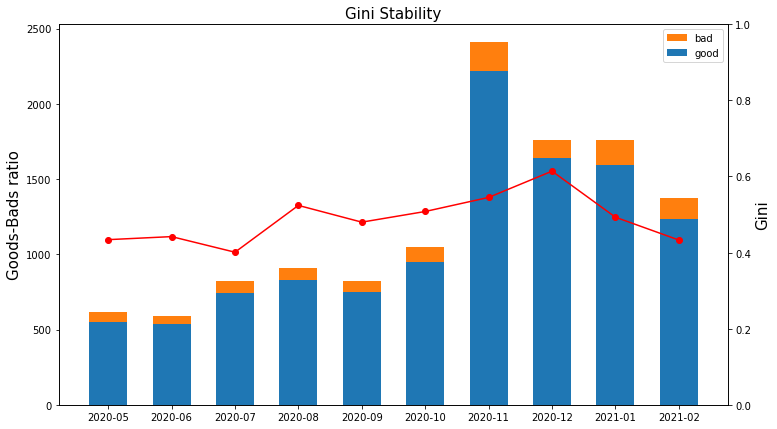

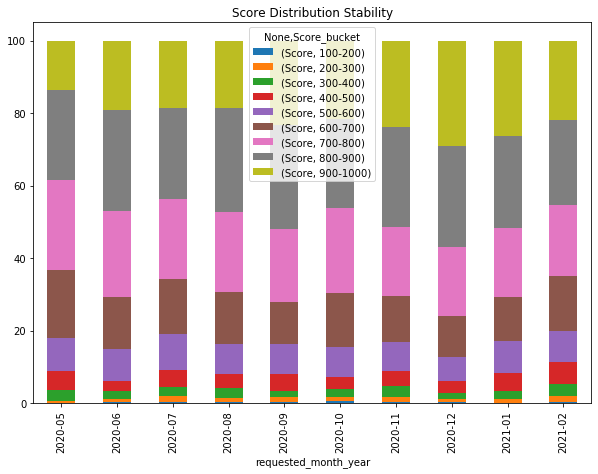

In [313]:
Ginis = create_gini_stability(df3, model, X_train[vars_woe])

pic_folder = 'pic/'  # Папка, в которую сохранятся картинки, надо отдельно создать её.
period_date = 1  # Период с которым будут отображаться даты на графике
gini_stability_chart(Ginis, pic_folder=pic_folder, period_date=period_date)
score_stability_graph(table, pic_folder=pic_folder)

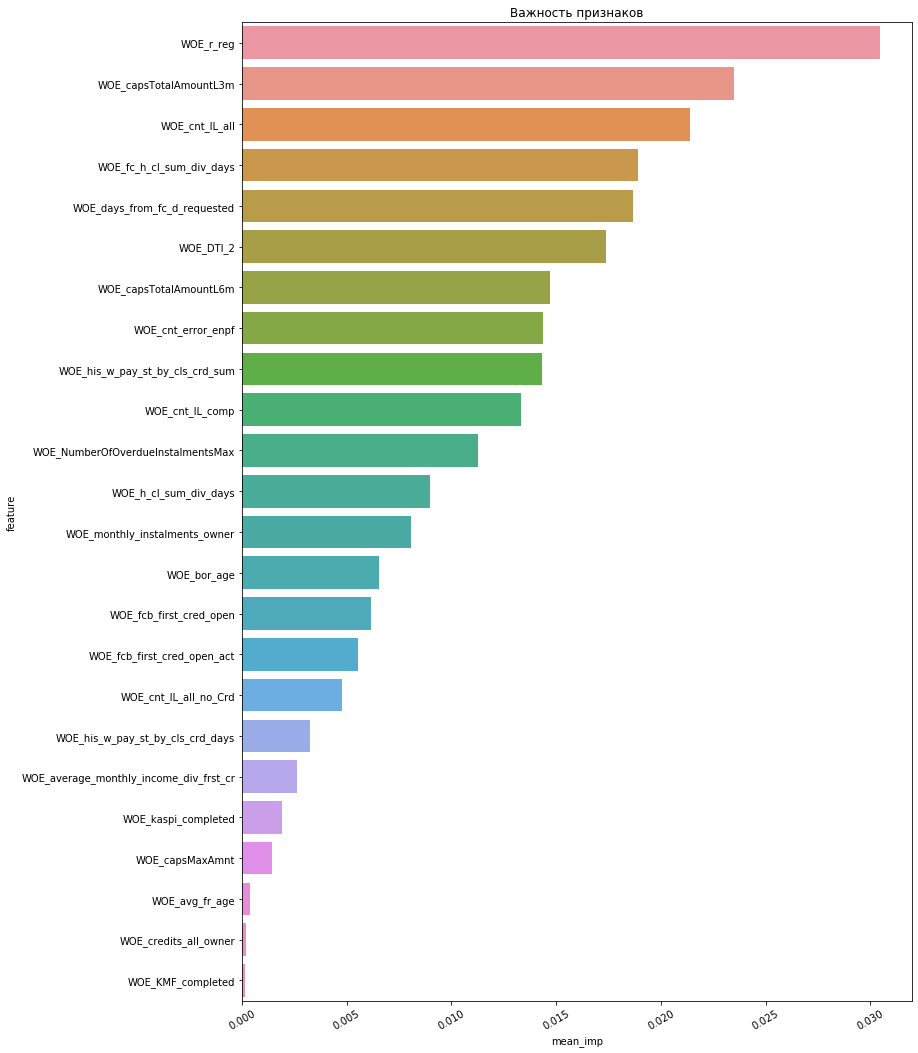

In [314]:
# feature_importance = tf_imp[tf_imp['feature'].isin(vars_woe)]
feature_importance = perm_imp
feat_imp_parts = plot_feature_importances(feature_importance, pic_folder=pic_folder)

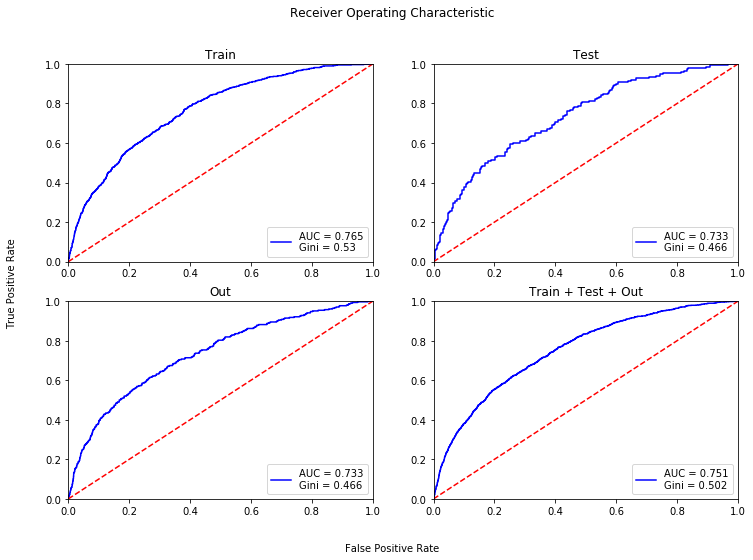

In [315]:
X_all = df3.copy()
y_all = df3['target'].copy()

plot_roc_curve(model, vars_woe, X_all, y_all, X_train, y_train, X_test, y_test,
                 X_out, y_out, pic_folder=pic_folder)

In [316]:
# Считаем однофакторный gini для train, test, out.
gini_by_vars = gini_univariate(X_train, X_test, X_out, y_train, y_test, y_out, vars_woe)
gini_by_vars

,vars,gini_train,gini_test,gini_out
0,WOE_cnt_IL_all,0.277,0.288,0.289
9,WOE_cnt_IL_comp,0.267,0.278,0.293
5,WOE_cnt_IL_all_no_Crd,0.258,0.257,0.292
7,WOE_credits_all_owner,0.255,0.232,0.282
6,WOE_capsTotalAmountL3m,0.231,0.175,0.191
3,WOE_capsTotalAmountL6m,0.226,0.159,0.179
21,WOE_capsMaxAmnt,0.219,0.186,0.175
18,WOE_bor_age,0.21,0.161,0.210
11,WOE_fcb_first_cred_open,0.204,0.207,0.230
19,WOE_NumberOfOverdueInstalmentsMax,0.188,0.197,0.246


In [317]:
# Считаем однофакторный gini по месяцам.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week.
_, df_gini_months = gini_month_selection(df3[vars_woe], df3, date_name=date_name, intervals=intervals)
df_gini_months

,vars,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02
0,WOE_cnt_IL_all,0.187,0.042,0.331,0.249,0.303,0.306,0.291,0.364,0.285,0.292
1,WOE_his_w_pay_st_by_cls_crd_sum,0.080,-0.013,0.089,0.178,0.073,0.113,0.129,0.271,0.137,0.101
2,WOE_DTI_2,0.095,0.092,0.075,0.141,0.211,0.117,0.163,0.202,0.090,0.044
3,WOE_capsTotalAmountL6m,0.216,0.266,0.196,0.294,0.220,0.135,0.198,0.205,0.197,0.155
4,WOE_kaspi_completed,0.156,0.069,0.143,0.169,0.201,0.204,0.139,0.206,0.242,0.161
5,WOE_cnt_IL_all_no_Crd,0.198,0.025,0.274,0.208,0.292,0.303,0.268,0.338,0.310,0.270
6,WOE_capsTotalAmountL3m,0.216,0.214,0.183,0.318,0.213,0.143,0.200,0.246,0.207,0.168
7,WOE_credits_all_owner,0.170,0.030,0.335,0.214,0.308,0.224,0.275,0.332,0.301,0.259
8,WOE_KMF_completed,0.076,0.002,0.158,0.090,0.157,0.208,0.135,0.190,0.203,0.139
9,WOE_cnt_IL_comp,0.178,0.074,0.325,0.238,0.306,0.306,0.262,0.346,0.330,0.249


In [318]:
# Create ivi to excel
ivs = ivs_to_excel(iv_df, X_train[vars_woe])

# Score and IV groups
ivs = iv_groups(ivs)
# ivs = add_score(ivs, feat, y_train)
feat = pd.DataFrame(vars_woe, columns=['Feature'])

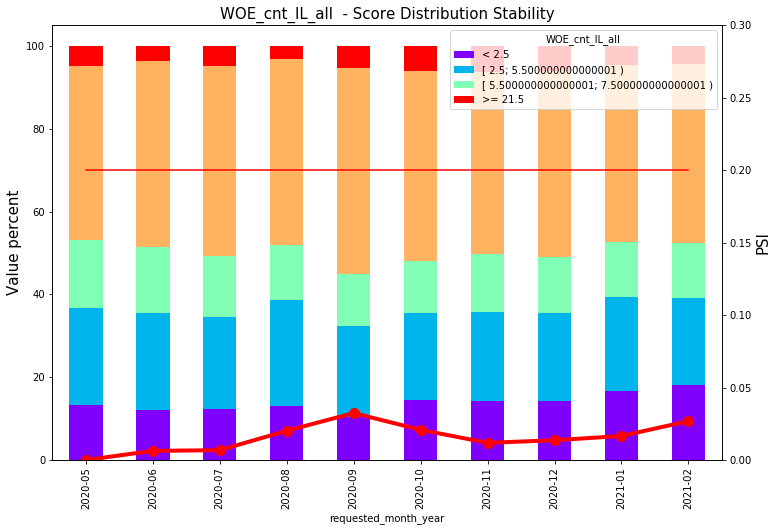

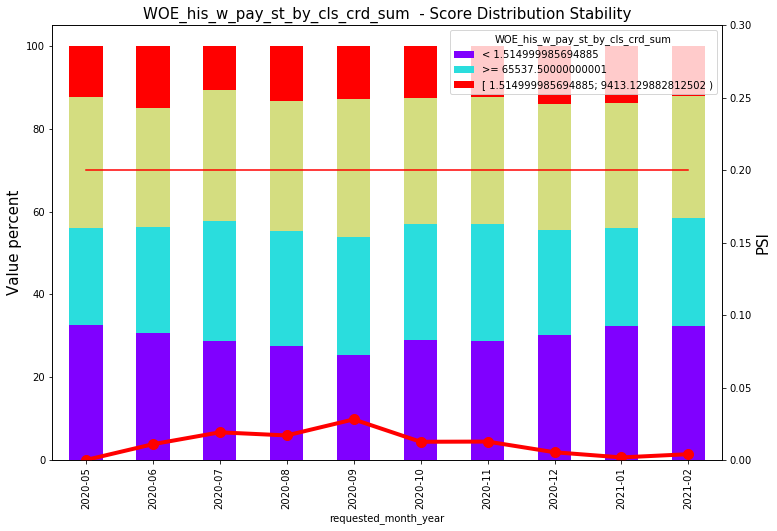

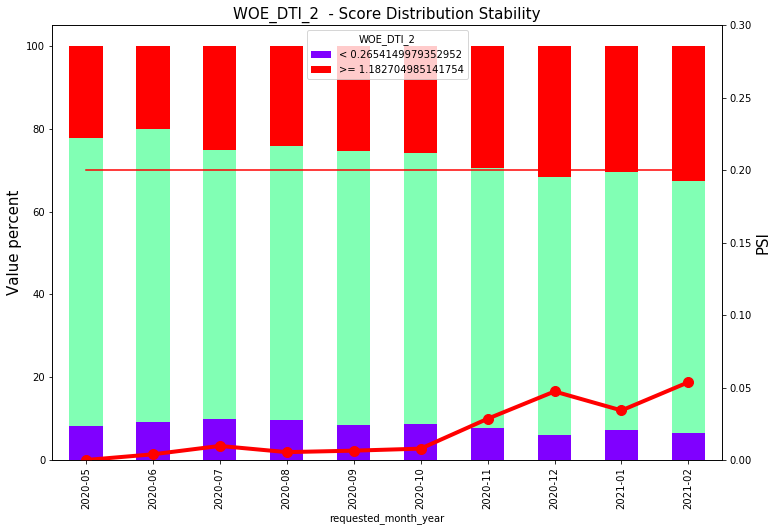

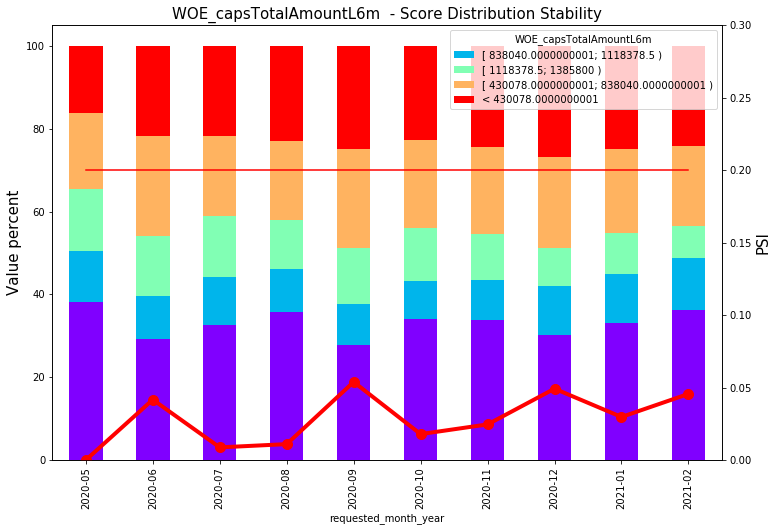

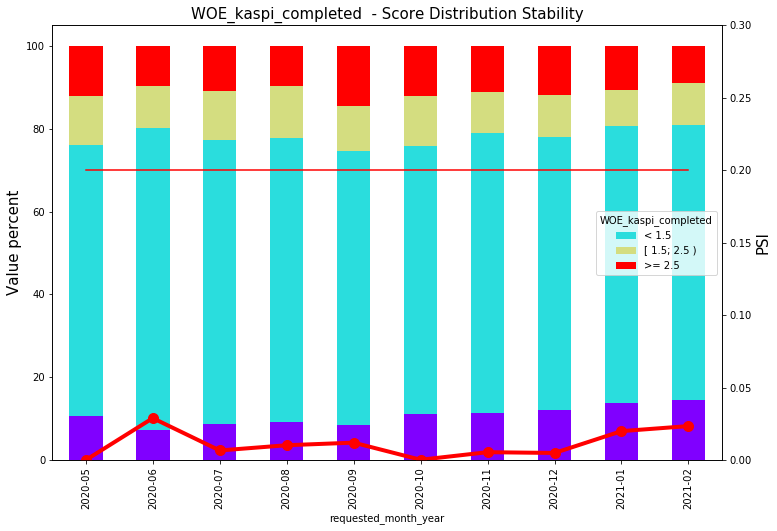

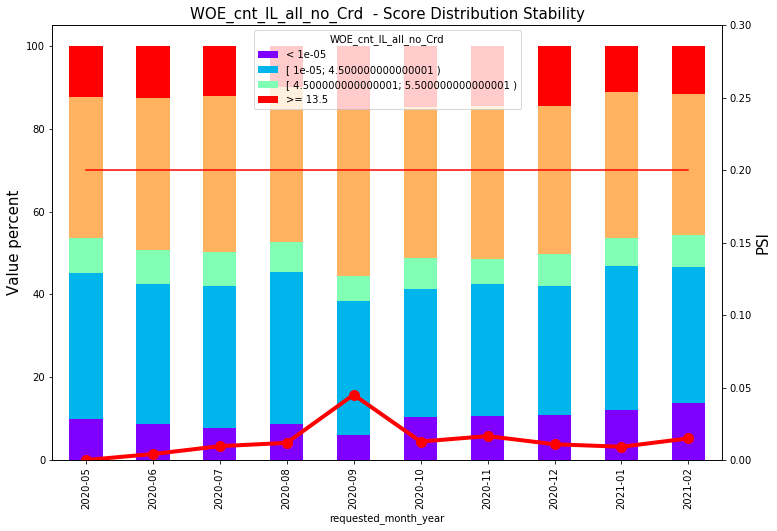

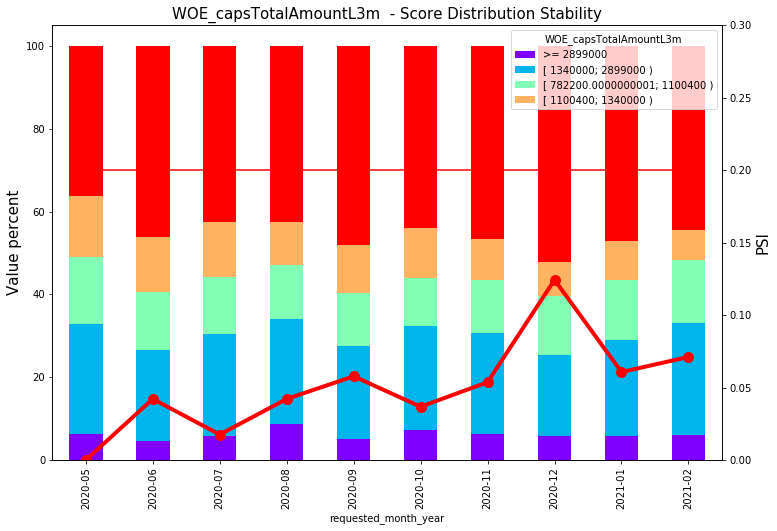

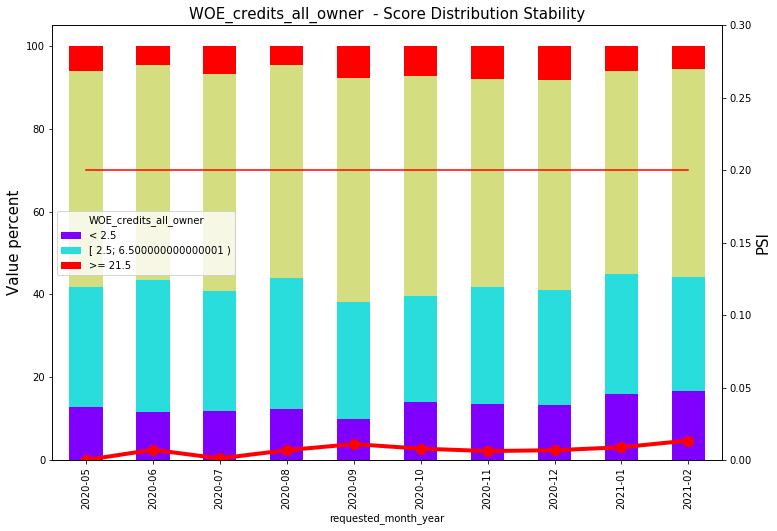

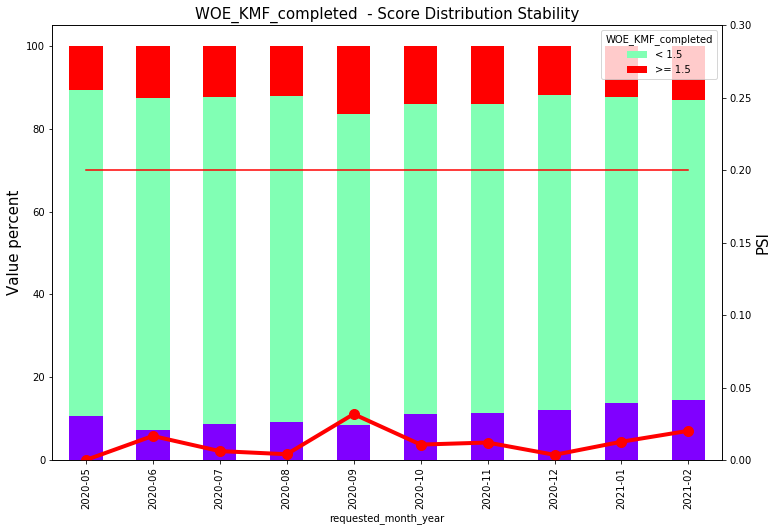

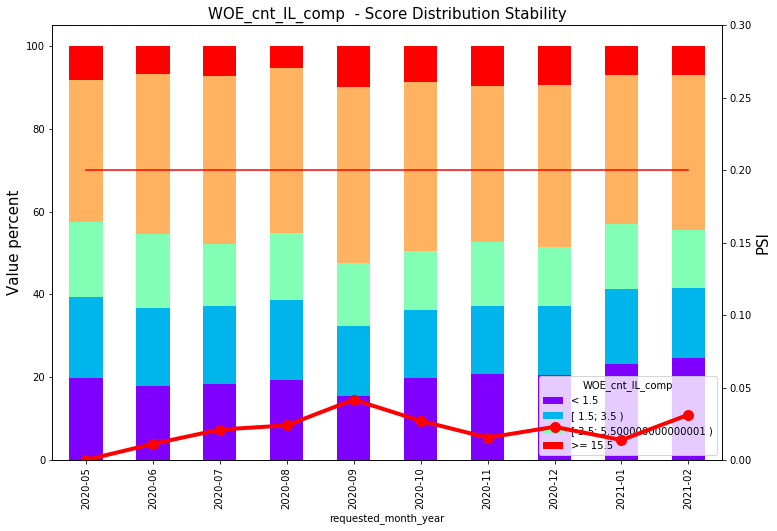

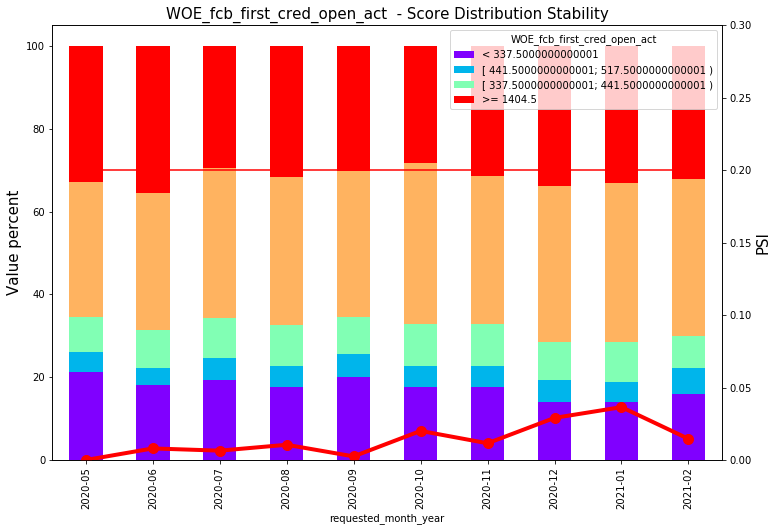

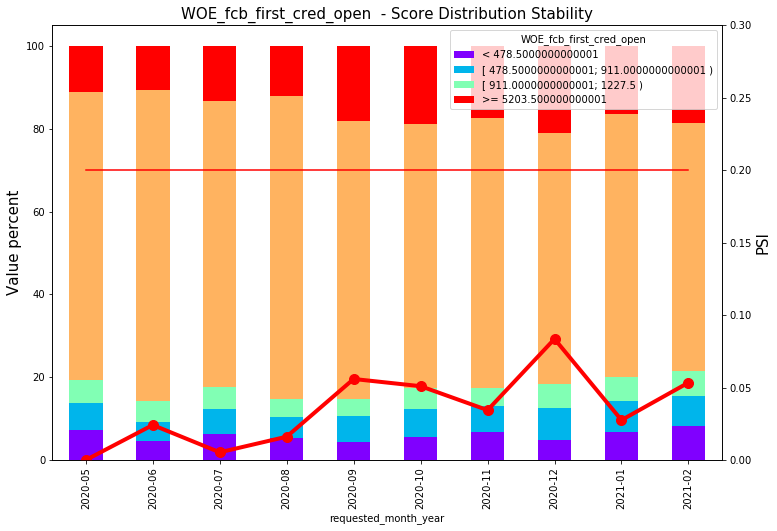

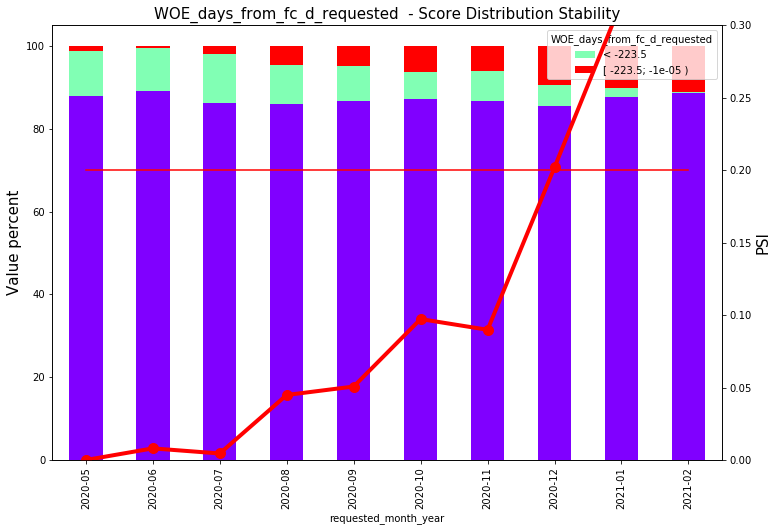

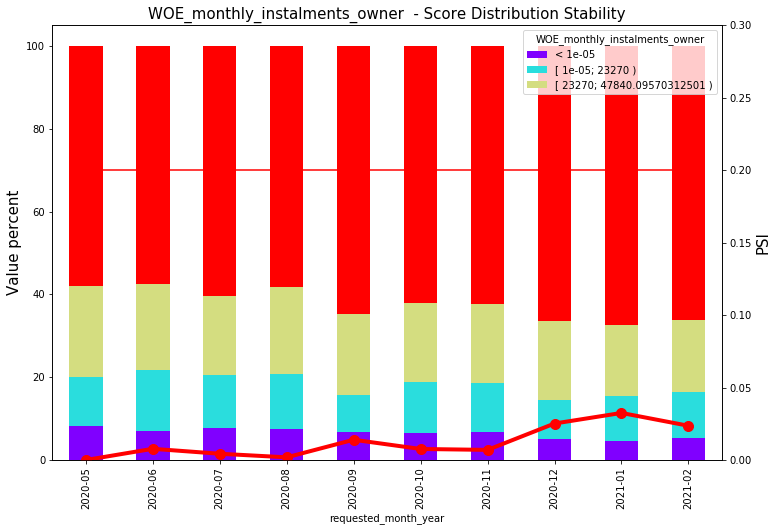

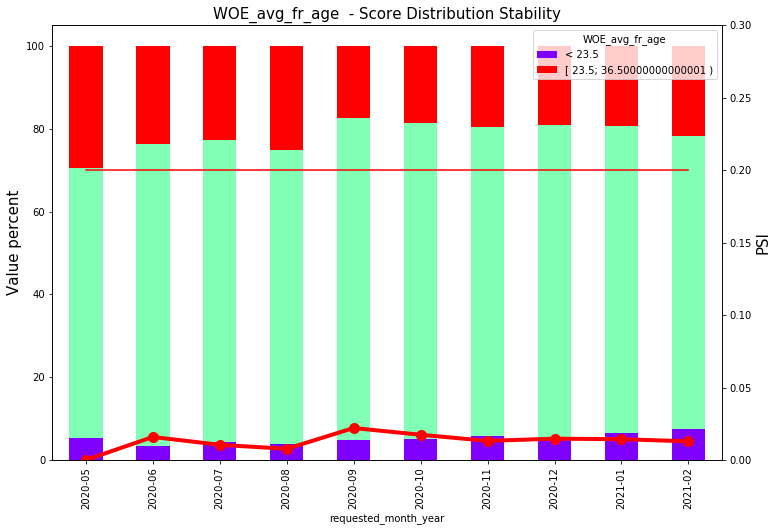

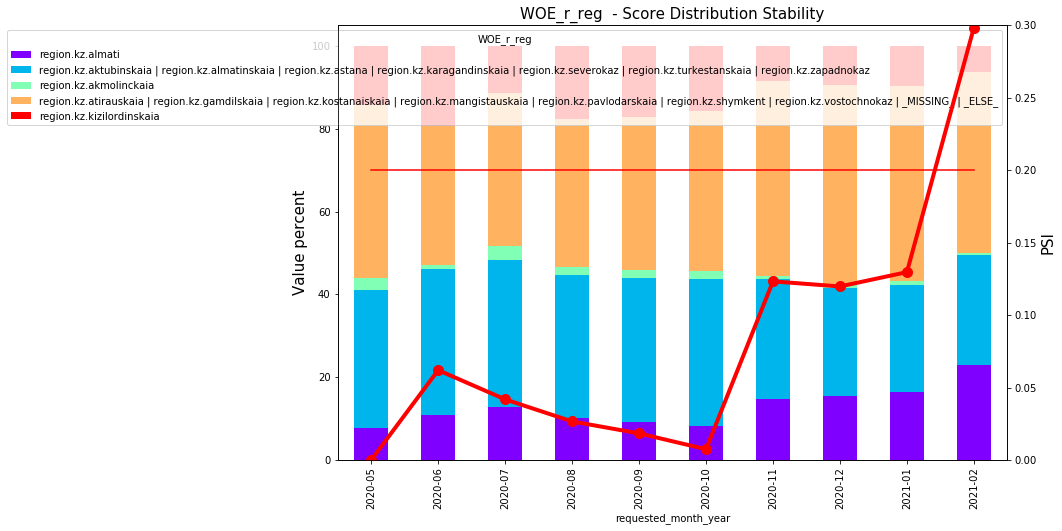

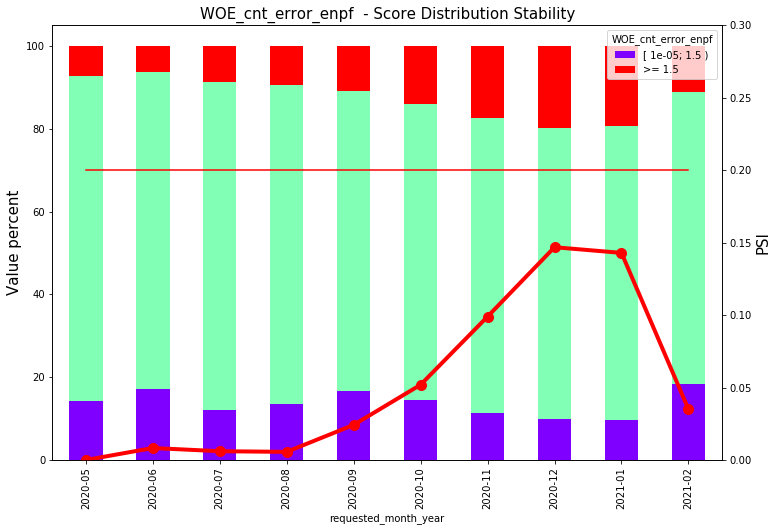

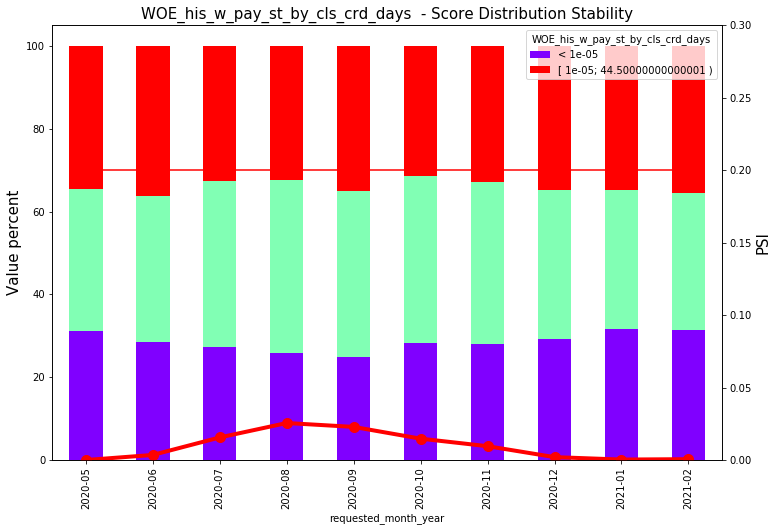

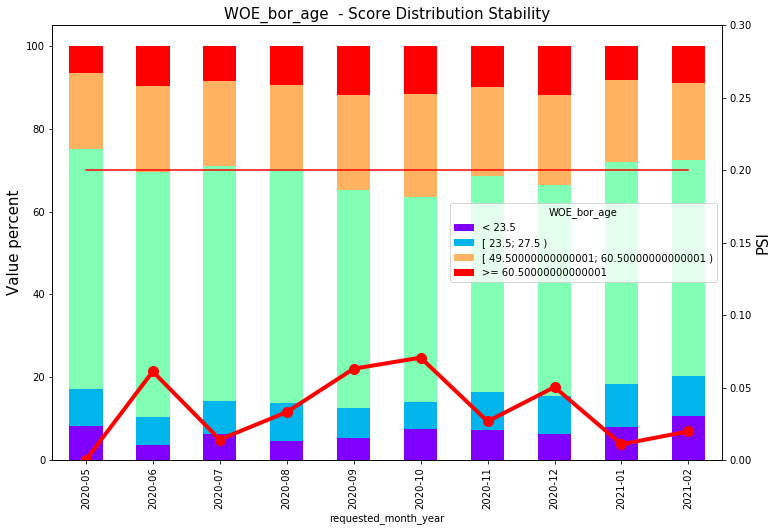

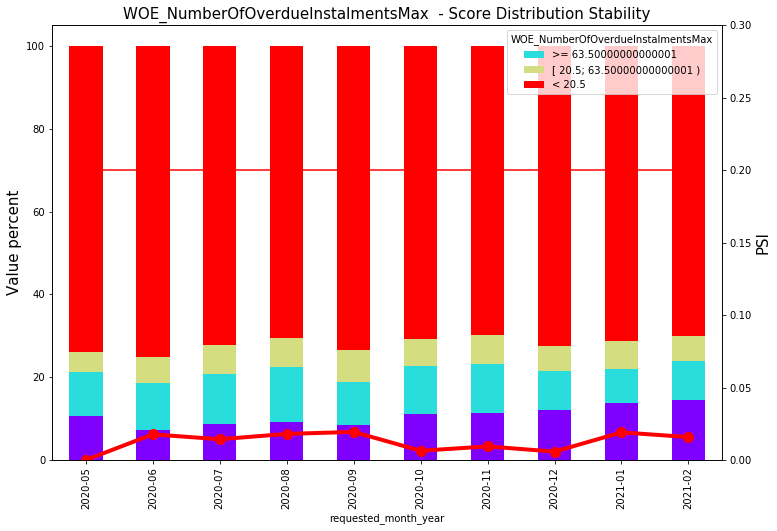

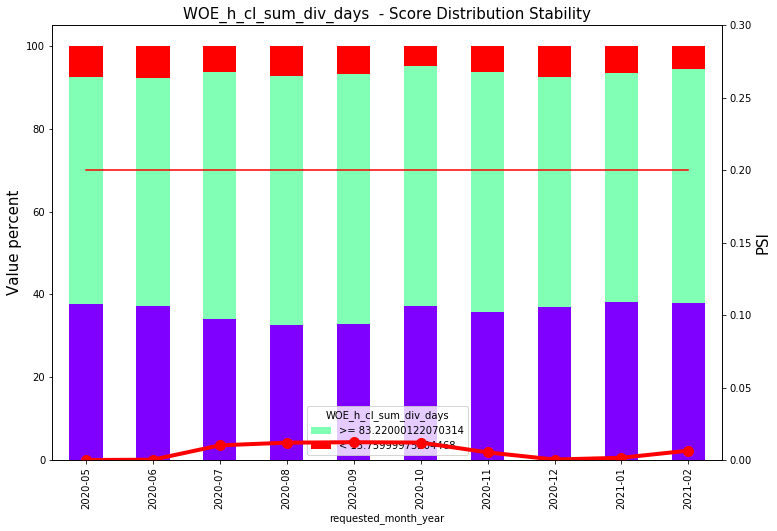

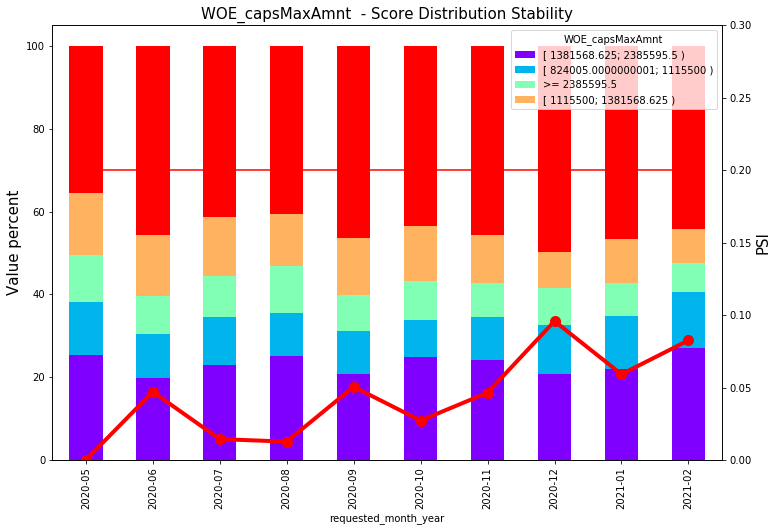

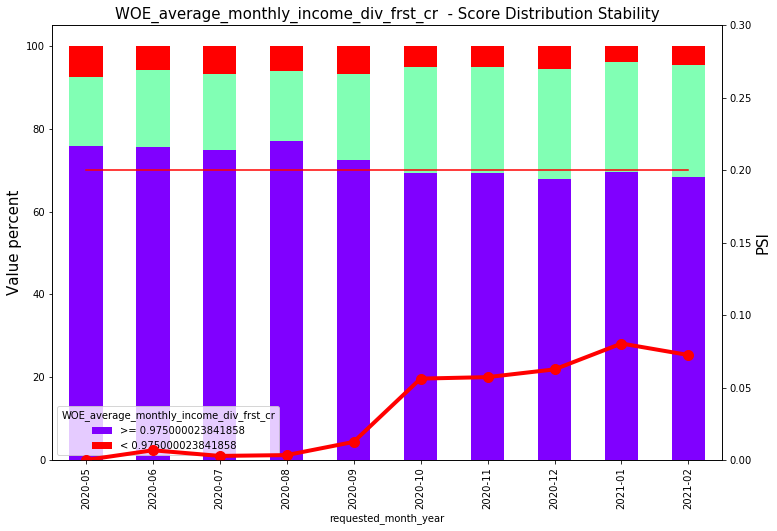

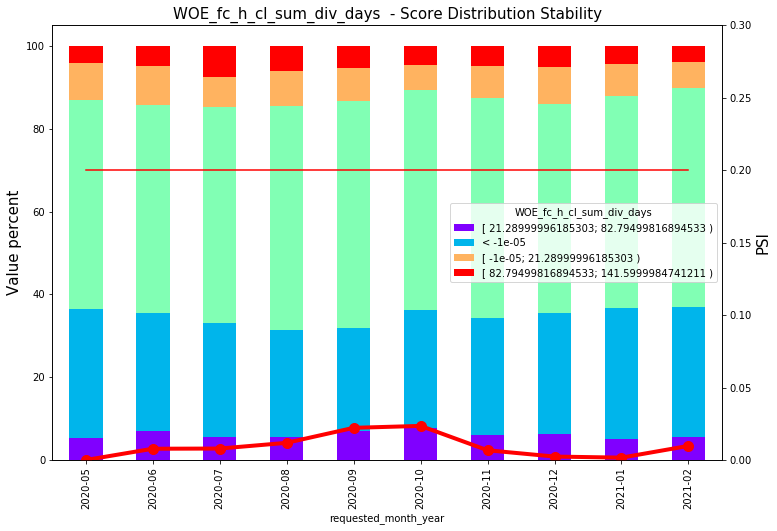

In [319]:
month_num = 0  # Номер месяца от которого отталкиваться в расчёте psi.
date_name = DATE  # имя столбца даты по которому делить на месяцы
features_of_model = population_stability(df3, ivs, feat, month_num=month_num, pic_folder=pic_folder, date_name=date_name)

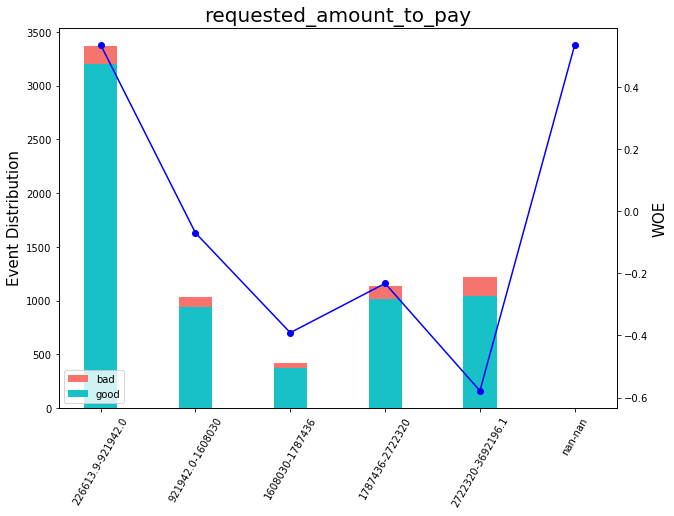

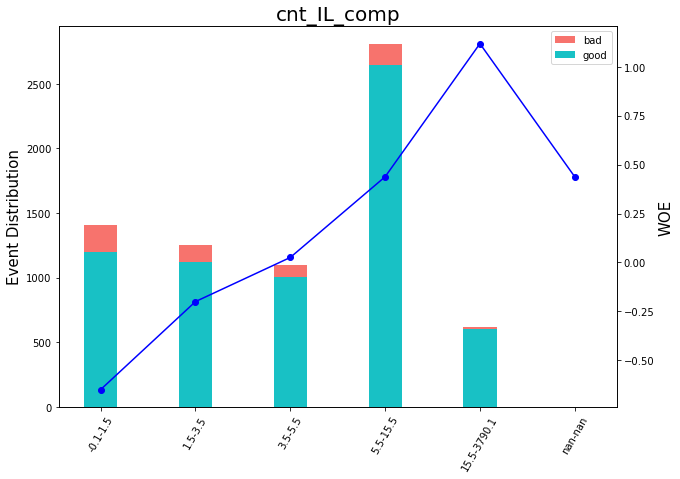

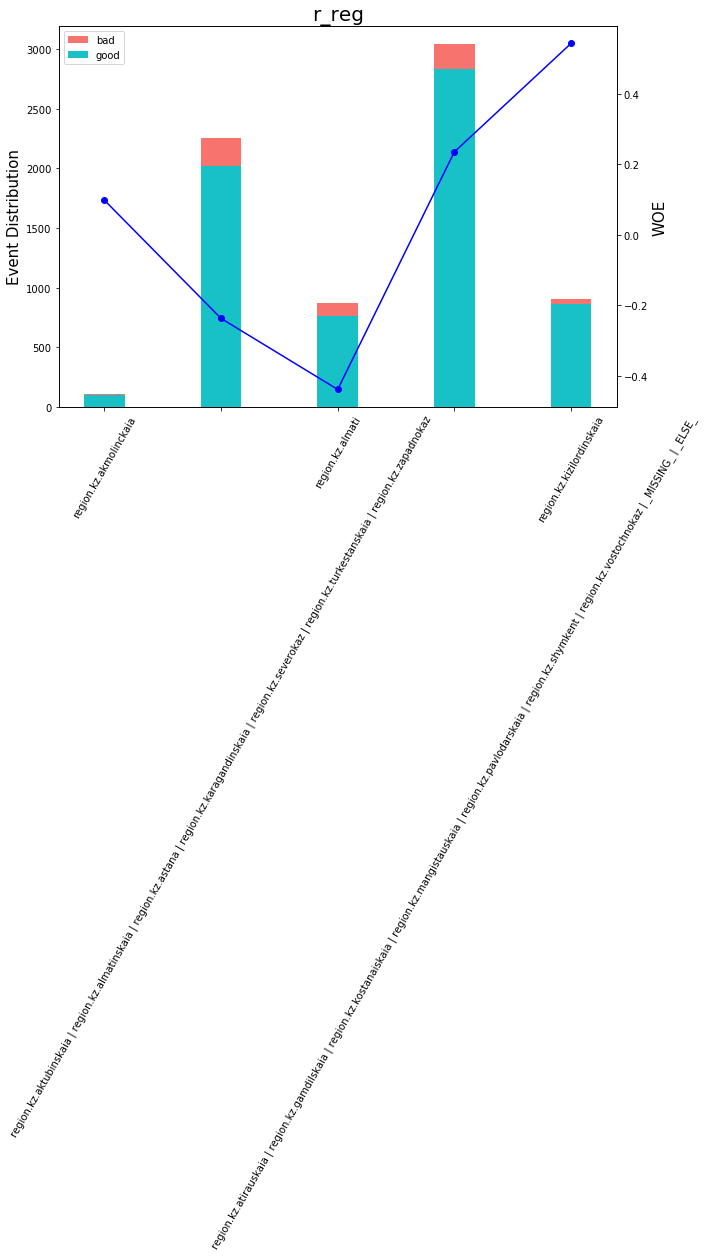

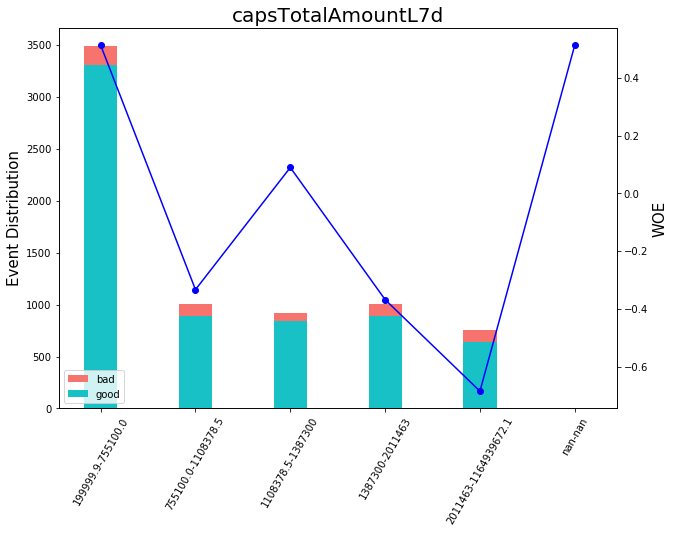

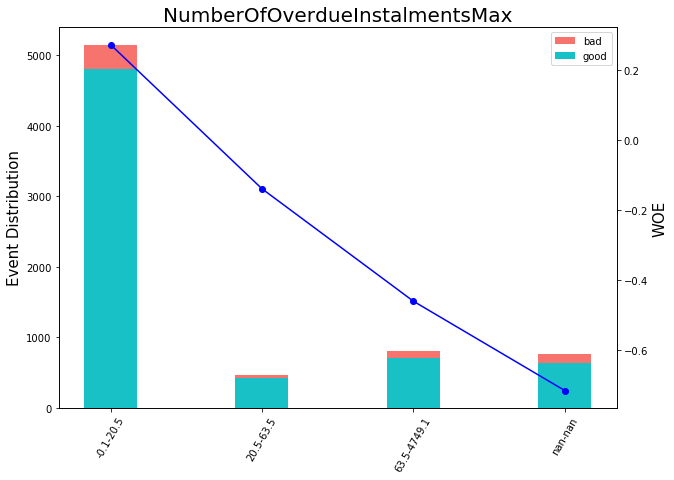

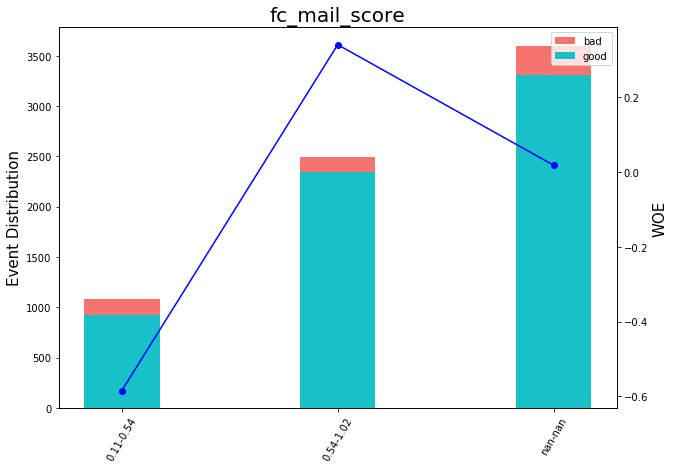

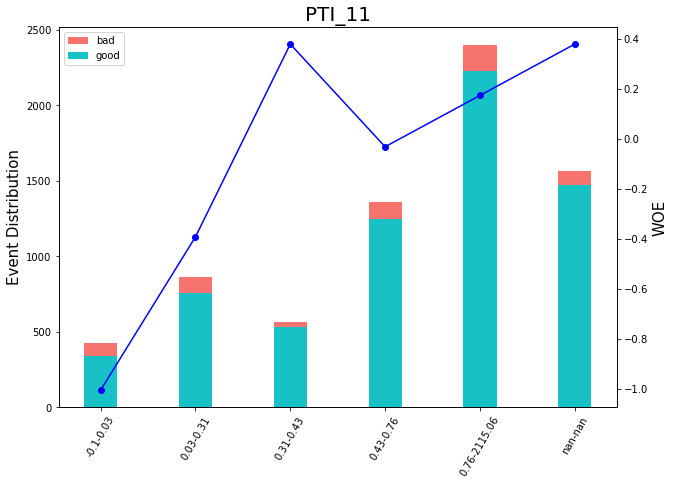

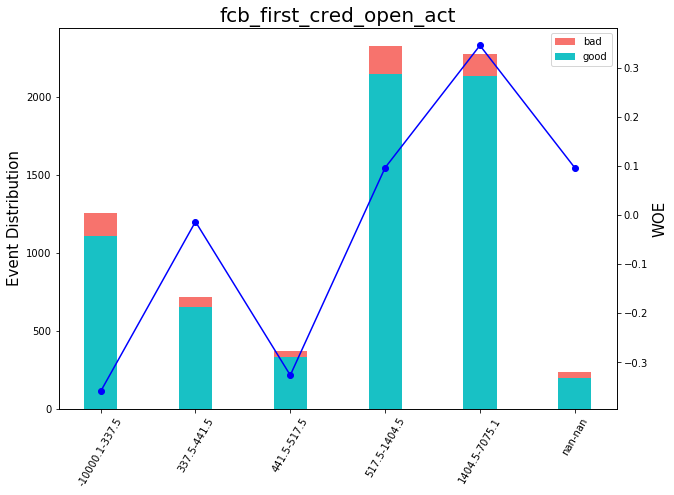

In [113]:
plot_all_bins(iv_df, X_train[vars_woe], pic_folder=pic_folder)

#### Формирование итогового excel файла

In [ ]:
model = sm.Logit(y_train, X_train[vars_woe])
model_fit = model.fit()
model_fit.pvalues

PV = pd.DataFrame(data=model_fit.pvalues, columns=['pv_train'])
PV = PV.sort_values(by='pv_train', ascending=False)
# PV.to_excel('results/pvalues.xlsx')

Optimization terminated successfully.
         Current function value: 0.582207
         Iterations 5


In [117]:
target_description = 'npl1_3mob'
model_description = 'Скоркарта Solva KZ сегмента street'

DSL = ''

if type(model) == LinearTreeClassifier:
    SQL = convert_linear_tree_to_sql(model, vars_woe, iv_df)
elif type(model) in (DecisionTreeClassifier, RandomForestClassifier):
    SQL = convert_model_to_sql(model, vars_woe, iv_df)

name_2 = 'report/slkz_solvaStreet_score_model_v1.1'

export_to_excel_model(
    X_train=X_train[vars_woe],
    X_test=X_test[vars_woe],
    y_train=y_train,
    y_test=y_test,
    y=y,
    df3=df3,
    iv_df=iv_df,
    Ginis=Ginis,
    table=table,
    scores=scores,
    feat=vars_woe,
    clf_lr=model,
    ivs=ivs,
    df_gini_months=df_gini_months,
    DSL=DSL,
    SQL=SQL,
    X_out=X_out[vars_woe],
    y_out=y_out,
    name=name_2,
    pic_folder='pic/',
    target_description=target_description,
    model_description=model_description,
    date_name='date_requested'
)

Exported!
